In [1]:
import geopandas as gpd
import pandas as pd
import rasterio
import rioxarray as rxr
import os
import rasterstats as rs
import fiona
import matplotlib.pyplot as plt
import numpy as np

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Vector file import (2 methods)

In [2]:
# tracts = fiona.open('data/la_tracts.geojson')

In [3]:
tracts_geodf = gpd.GeoDataFrame.from_file('data/la_tracts.geojson')

In [4]:
tracts_geodf

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,037,599100,06037599100,5991,Census Tract 5991,G5020,S,337352192,1098469237,+32.9255700,-118.4972902,"MULTIPOLYGON (((-118.41663 32.79555, -118.4165..."
1,06,059,001710,06059001710,17.10,Census Tract 17.10,G5020,S,3166634,0,+33.9002308,-117.9684399,"MULTIPOLYGON (((-117.97659 33.90282, -117.9765..."
2,06,029,003308,06029003308,33.08,Census Tract 33.08,G5020,S,76355354,30155,+34.8432832,-118.9897489,"MULTIPOLYGON (((-118.88954 34.81790, -118.8847..."
3,06,037,137000,06037137000,1370,Census Tract 1370,G5020,S,3006590,4374,+34.1661153,-118.6402345,"MULTIPOLYGON (((-118.65862 34.17142, -118.6584..."
4,06,037,541605,06037541605,5416.05,Census Tract 5416.05,G5020,S,872792,0,+33.8993442,-118.2100023,"MULTIPOLYGON (((-118.21630 33.90339, -118.2153..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,06,037,189600,06037189600,1896,Census Tract 1896,G5020,S,1070644,0,+34.1112603,-118.3297989,"MULTIPOLYGON (((-118.33698 34.10837, -118.3369..."
2529,06,037,189400,06037189400,1894,Census Tract 1894,G5020,S,1446823,0,+34.1200812,-118.3211428,"MULTIPOLYGON (((-118.32676 34.11112, -118.3267..."
2530,06,037,181400,06037181400,1814,Census Tract 1814,G5020,S,879184,0,+34.1367194,-118.2088736,"MULTIPOLYGON (((-118.21897 34.14000, -118.2173..."
2531,06,059,001401,06059001401,14.01,Census Tract 14.01,G5020,S,1592982,15869,+33.9408240,-117.9410039,"MULTIPOLYGON (((-117.93305 33.94609, -117.9330..."


In [5]:
tracts_geodf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [6]:
tracts_geodf.total_bounds

array([-118.94464139,   32.79520335, -117.64638732,   34.82330466])

In [7]:
tracts_geodf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

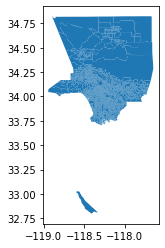

In [8]:
tracts_geodf.plot()

### Land Cover Categorical Raster

In [25]:
land_src = rasterio.open('data/crs/land_latlong.tif')
land_transform = land_src.meta['transform']
land_transform

Affine(0.00024335671691573372, 0.0, -120.072950519,
       0.0, -0.0003227497484961333, 35.592335218)

In [26]:
land_transform_manual = (-120.072950519, 0.00024335671691573372, 0.0, 35.592335218, 0.0, -0.0003227497484961333)

In [27]:
land_arr = land_src.read(1)
land_arr

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

#### Confirm crs for raster

In [28]:
land_src.bounds

BoundingBox(left=-120.072950519, bottom=32.212177102, right=-115.790115658, top=35.592335218)

### Urban Imperviousness Raster

In [29]:
impv_src = rasterio.open('data/crs/impv_latlong.tif')
impv_transform = impv_src.meta['transform']
impv_transform

Affine(0.00024335671691573372, 0.0, -120.072950519,
       0.0, -0.0003227497484961333, 35.592335218)

In [30]:
impv_transform_manual = (-120.072950519, 0.00024335671691573372, 0.0, 35.592335218, 0.0, -0.0003227497484961333)

In [31]:
impv_arr = impv_src.read(1)

### Tree Canopy Raster

In [32]:
tree_src = rasterio.open('data/crs/trees_latlong.tif')
tree_transform = tree_src.meta['transform']
tree_transform

Affine(0.00024335671691573372, 0.0, -120.072950519,
       0.0, -0.0003227497485916166, 35.592335219)

In [33]:
tree_transform_manual = (-120.072950519, 0.00024335671691573372, 0.0, 35.592335218, 0.0, -0.0003227497484961333)

In [34]:
tree_arr = tree_src.read(1)

### Digital Elevation Raster

In [35]:
dem_src = rasterio.open('data/usgs_merged.tif')
dem_dict = dem_src.profile
dem_dict

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 7212, 'height': 10812, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(0.0002777777777780007, 0.0, -119.001666667182,
       0.0, -0.0002777777777780007, 35.0016666670839), 'tiled': False, 'interleave': 'band'}

In [36]:
dem_aff = dem_dict['transform']
dem_transform_manual = (-119.001666667182, 0.0002777777777780007, 0.0, 35.0016666670839, 0.0, -0.0002777777777780007)

In [37]:
dem_arr = dem_src.read(1)

### Visualizing land raster data

In [22]:
# fig, ax = plt.subplots(figsize=(10,10))
# landplot = ax.imshow(land_src.read(1), cmap='tab20')
# ax.set_title("MRLC Land Cover, 2019", fontsize=14)
# cbar = fig.colorbar(landplot, fraction=0.035, pad=0.01, extend='both')
# cbar.ax.get_yaxis().labelpad = 15
# cbar.ax.set_ylabel('Anderson Level II Classification', rotation=90)
# plt.show()

In [23]:
# fig, ax = plt.subplots(figsize=(10,10))
# impvplot = ax.imshow(impv_src.read(1), cmap='inferno')
# ax.set_title("MRLC Degree of Imperviousness, 2019", fontsize=14)
# cbar = fig.colorbar(impvplot, fraction=0.035, pad=0.01, extend='both')
# cbar.ax.get_yaxis().labelpad = 15
# cbar.ax.set_ylabel('y label', rotation=90)
# plt.show()

## Zonal stats for each raster

#### simplest form of rasterstats:

In [38]:
impv_stats = rs.zonal_stats(tracts_geodf, 
                         impv_arr, 
                         stats='median mean min max',
                         copy_properties=True,
                         transform=impv_transform_manual, 
                         nodata=-9999)

In [39]:
impv_stats

[{'min': 0.0, 'max': 100.0, 'mean': 0.9569370351407447, 'median': 0.0},
 {'median': None, 'mean': None, 'min': None, 'max': None},
 {'min': 21.0, 'max': 100.0, 'mean': 44.06666666666667, 'median': 43.0},
 {'min': 0.0, 'max': 100.0, 'mean': 45.807251399626765, 'median': 46.0},
 {'min': 8.0, 'max': 100.0, 'mean': 71.75934366453966, 'median': 69.0},
 {'min': 16.0, 'max': 100.0, 'mean': 65.44644870349492, 'median': 65.0},
 {'min': 5.0, 'max': 100.0, 'mean': 63.5466472303207, 'median': 62.0},
 {'min': 0.0, 'max': 100.0, 'mean': 62.31031613976705, 'median': 60.0},
 {'min': 0.0, 'max': 100.0, 'mean': 56.61429322122964, 'median': 58.0},
 {'min': 6.0, 'max': 100.0, 'mean': 66.02771362586606, 'median': 67.0},
 {'min': 0.0, 'max': 100.0, 'mean': 62.974845542806705, 'median': 62.0},
 {'min': 1.0, 'max': 100.0, 'mean': 62.94140625, 'median': 62.0},
 {'min': 0.0, 'max': 100.0, 'mean': 65.52190476190476, 'median': 64.0},
 {'min': 0.0, 'max': 100.0, 'mean': 70.65386922615477, 'median': 72.0},
 {'min':

In [40]:
tree_stats = rs.zonal_stats(tracts_geodf, 
                            tree_arr,
                            stats = 'median mean min max',
                            transform=tree_transform_manual, 
                            nodata=-9999)

In [41]:
tree_stats

[{'min': 0.0, 'max': 53.0, 'mean': 0.2153038135663204, 'median': 0.0},
 {'median': None, 'mean': None, 'min': None, 'max': None},
 {'min': 0.0, 'max': 0.0, 'mean': 0.0, 'median': 0.0},
 {'min': 0.0, 'max': 47.0, 'mean': 8.745667821914155, 'median': 6.0},
 {'min': 0.0, 'max': 12.0, 'mean': 1.4010938924339107, 'median': 0.0},
 {'min': 0.0, 'max': 16.0, 'mean': 2.2773393461104847, 'median': 0.0},
 {'min': 0.0, 'max': 17.0, 'mean': 2.123906705539359, 'median': 0.0},
 {'min': 0.0, 'max': 23.0, 'mean': 2.488352745424293, 'median': 0.0},
 {'min': 0.0, 'max': 44.0, 'mean': 4.685759327377824, 'median': 0.0},
 {'min': 0.0, 'max': 40.0, 'mean': 1.3187066974595842, 'median': 0.0},
 {'min': 0.0, 'max': 30.0, 'mean': 4.246690203000883, 'median': 4.0},
 {'min': 0.0, 'max': 26.0, 'mean': 3.330295138888889, 'median': 0.0},
 {'min': 0.0, 'max': 30.0, 'mean': 2.9606349206349205, 'median': 0.0},
 {'min': 0.0, 'max': 44.0, 'mean': 3.0821835632873427, 'median': 0.0},
 {'min': 0.0, 'max': 26.0, 'mean': 2.855

In [42]:
land_stats = rs.zonal_stats(tracts_geodf, 
                         land_arr, 
                         stats="majority",
                         copy_properties=True,
                         transform=land_transform_manual, 
                         nodata=-9999)

In [43]:
land_stats

[{'majority': 52.0},
 {'majority': None},
 {'majority': 22.0},
 {'majority': 22.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 24.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 22.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 24.0},
 {'majority': 24.0},
 {'majority': 22.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 24.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': 23.0},
 {'majority': None},
 {'majority': 24.0},
 {'majority': 24.0},
 {'majority': 24.0},
 {'majority': 24.0},
 {'majority':

In [165]:
# legend = np.array([0,11,12,21,22,23,24,31,41,42,43,51,52,71,72,73,74,81,82,90,95])
# leg_str = np.array(['NaN','Open Water','Perennial Ice/Snow','Developed, Open Space','Developed, Low Intensity',
#            'Developed, Medium Intensity','Developed High Intensity','Barren Land (Rock/Sand/Clay)',
#            'Deciduous Forest','Evergreen Forest','Mixed Forest','Dwarf Scrub','Shrub/Scrub',
#            'Grassland/Herbaceous','Sedge/Herbaceous','Lichens','Moss','Pasture/Hay','Cultivated Crops',
#            'Woody Wetlands','Emergent Herbaceous Wetlands'])

In [46]:
dem_stats = rs.zonal_stats(tracts_geodf, dem_arr, stats = 'median mean min max',
                        transform = dem_transform_manual, nodata=-9999)

In [47]:
dem_stats

[{'min': -0.6592308282852173,
  'max': 598.944580078125,
  'mean': 226.11016536701962,
  'median': 209.0658416748047},
 {'median': None, 'mean': None, 'min': None, 'max': None},
 {'min': 1184.0245361328125,
  'max': 1185.452392578125,
  'mean': 1184.7476399739583,
  'median': 1184.765869140625},
 {'min': 258.5460205078125,
  'max': 328.79083251953125,
  'mean': 281.20617608409987,
  'median': 277.1546630859375},
 {'min': 20.29071617126465,
  'max': 23.055477142333984,
  'mean': 21.50871310763889,
  'median': 21.491050720214844},
 {'min': 22.660171508789062,
  'max': 32.831417083740234,
  'mean': 24.308732024336283,
  'median': 24.059566497802734},
 {'min': 21.06571388244629,
  'max': 33.38902282714844,
  'mean': 24.44026343437053,
  'median': 23.95224380493164},
 {'min': 21.471960067749023,
  'max': 24.188756942749023,
  'mean': 22.89697225765306,
  'median': 22.920475006103516},
 {'min': 5.791260719299316,
  'max': 16.31064224243164,
  'mean': 9.985990887454356,
  'median': 9.87622070

### Join zonal stats to census tracts

#### Tree stats to vector

In [48]:
tree_tracts = tracts_geodf.join(pd.DataFrame(tree_stats))

In [49]:
tree_tracts.rename(columns={'min': 'tree_min', 'max': 'tree_max', 'mean': 'tree_mean', 
                            'median': 'tree_median'}, inplace = True)

In [50]:
tree_tracts

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,tree_min,tree_max,tree_mean,tree_median
0,06,037,599100,06037599100,5991,Census Tract 5991,G5020,S,337352192,1098469237,+32.9255700,-118.4972902,"MULTIPOLYGON (((-118.41663 32.79555, -118.4165...",0.0,53.0,0.215304,0.0
1,06,059,001710,06059001710,17.10,Census Tract 17.10,G5020,S,3166634,0,+33.9002308,-117.9684399,"MULTIPOLYGON (((-117.97659 33.90282, -117.9765...",NaN,NaN,NaN,NaN
2,06,029,003308,06029003308,33.08,Census Tract 33.08,G5020,S,76355354,30155,+34.8432832,-118.9897489,"MULTIPOLYGON (((-118.88954 34.81790, -118.8847...",0.0,0.0,0.000000,0.0
3,06,037,137000,06037137000,1370,Census Tract 1370,G5020,S,3006590,4374,+34.1661153,-118.6402345,"MULTIPOLYGON (((-118.65862 34.17142, -118.6584...",0.0,47.0,8.745668,6.0
4,06,037,541605,06037541605,5416.05,Census Tract 5416.05,G5020,S,872792,0,+33.8993442,-118.2100023,"MULTIPOLYGON (((-118.21630 33.90339, -118.2153...",0.0,12.0,1.401094,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,06,037,189600,06037189600,1896,Census Tract 1896,G5020,S,1070644,0,+34.1112603,-118.3297989,"MULTIPOLYGON (((-118.33698 34.10837, -118.3369...",0.0,42.0,9.065780,8.0
2529,06,037,189400,06037189400,1894,Census Tract 1894,G5020,S,1446823,0,+34.1200812,-118.3211428,"MULTIPOLYGON (((-118.32676 34.11112, -118.3267...",0.0,45.0,14.083056,12.0
2530,06,037,181400,06037181400,1814,Census Tract 1814,G5020,S,879184,0,+34.1367194,-118.2088736,"MULTIPOLYGON (((-118.21897 34.14000, -118.2173...",0.0,37.0,4.293796,0.0
2531,06,059,001401,06059001401,14.01,Census Tract 14.01,G5020,S,1592982,15869,+33.9408240,-117.9410039,"MULTIPOLYGON (((-117.93305 33.94609, -117.9330...",NaN,NaN,NaN,NaN


#### Land stats to vector

In [51]:
land_tracts = tracts_geodf.join(pd.DataFrame(land_stats))

In [52]:
land_tracts.rename(columns={'majority': 'land_majority'}, inplace = True)
land_tracts

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,land_majority
0,06,037,599100,06037599100,5991,Census Tract 5991,G5020,S,337352192,1098469237,+32.9255700,-118.4972902,"MULTIPOLYGON (((-118.41663 32.79555, -118.4165...",52.0
1,06,059,001710,06059001710,17.10,Census Tract 17.10,G5020,S,3166634,0,+33.9002308,-117.9684399,"MULTIPOLYGON (((-117.97659 33.90282, -117.9765...",NaN
2,06,029,003308,06029003308,33.08,Census Tract 33.08,G5020,S,76355354,30155,+34.8432832,-118.9897489,"MULTIPOLYGON (((-118.88954 34.81790, -118.8847...",22.0
3,06,037,137000,06037137000,1370,Census Tract 1370,G5020,S,3006590,4374,+34.1661153,-118.6402345,"MULTIPOLYGON (((-118.65862 34.17142, -118.6584...",22.0
4,06,037,541605,06037541605,5416.05,Census Tract 5416.05,G5020,S,872792,0,+33.8993442,-118.2100023,"MULTIPOLYGON (((-118.21630 33.90339, -118.2153...",23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,06,037,189600,06037189600,1896,Census Tract 1896,G5020,S,1070644,0,+34.1112603,-118.3297989,"MULTIPOLYGON (((-118.33698 34.10837, -118.3369...",23.0
2529,06,037,189400,06037189400,1894,Census Tract 1894,G5020,S,1446823,0,+34.1200812,-118.3211428,"MULTIPOLYGON (((-118.32676 34.11112, -118.3267...",22.0
2530,06,037,181400,06037181400,1814,Census Tract 1814,G5020,S,879184,0,+34.1367194,-118.2088736,"MULTIPOLYGON (((-118.21897 34.14000, -118.2173...",23.0
2531,06,059,001401,06059001401,14.01,Census Tract 14.01,G5020,S,1592982,15869,+33.9408240,-117.9410039,"MULTIPOLYGON (((-117.93305 33.94609, -117.9330...",NaN


#### Impv stats to vector

In [53]:
impv_tracts = tracts_geodf.join(pd.DataFrame(impv_stats))

In [54]:
impv_tracts.rename(columns={'min': 'impv_min', 'max': 'impv_max', 'mean': 'impv_mean', 
                            'median': 'impv_median'}, inplace = True)

#### Elevation (DEM) stats to vector

In [55]:
dem_tracts = tracts_geodf.join(pd.DataFrame(dem_stats))

In [56]:
dem_tracts.rename(columns={'min': 'dem_min', 'max': 'dem_max', 'mean': 'dem_mean', 
                            'median': 'dem_median'}, inplace = True)

In [57]:
dem_tracts

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,dem_min,dem_max,dem_mean,dem_median
0,06,037,599100,06037599100,5991,Census Tract 5991,G5020,S,337352192,1098469237,+32.9255700,-118.4972902,"MULTIPOLYGON (((-118.41663 32.79555, -118.4165...",-0.659231,598.944580,226.110165,209.065842
1,06,059,001710,06059001710,17.10,Census Tract 17.10,G5020,S,3166634,0,+33.9002308,-117.9684399,"MULTIPOLYGON (((-117.97659 33.90282, -117.9765...",NaN,NaN,NaN,NaN
2,06,029,003308,06029003308,33.08,Census Tract 33.08,G5020,S,76355354,30155,+34.8432832,-118.9897489,"MULTIPOLYGON (((-118.88954 34.81790, -118.8847...",1184.024536,1185.452393,1184.747640,1184.765869
3,06,037,137000,06037137000,1370,Census Tract 1370,G5020,S,3006590,4374,+34.1661153,-118.6402345,"MULTIPOLYGON (((-118.65862 34.17142, -118.6584...",258.546021,328.790833,281.206176,277.154663
4,06,037,541605,06037541605,5416.05,Census Tract 5416.05,G5020,S,872792,0,+33.8993442,-118.2100023,"MULTIPOLYGON (((-118.21630 33.90339, -118.2153...",20.290716,23.055477,21.508713,21.491051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,06,037,189600,06037189600,1896,Census Tract 1896,G5020,S,1070644,0,+34.1112603,-118.3297989,"MULTIPOLYGON (((-118.33698 34.10837, -118.3369...",127.204201,284.443512,175.437523,160.689148
2529,06,037,189400,06037189400,1894,Census Tract 1894,G5020,S,1446823,0,+34.1200812,-118.3211428,"MULTIPOLYGON (((-118.32676 34.11112, -118.3267...",152.534470,353.831543,237.594161,231.918854
2530,06,037,181400,06037181400,1814,Census Tract 1814,G5020,S,879184,0,+34.1367194,-118.2088736,"MULTIPOLYGON (((-118.21897 34.14000, -118.2173...",163.284958,229.218323,182.338486,179.166840
2531,06,059,001401,06059001401,14.01,Census Tract 14.01,G5020,S,1592982,15869,+33.9408240,-117.9410039,"MULTIPOLYGON (((-117.93305 33.94609, -117.9330...",NaN,NaN,NaN,NaN


### Workaround to convert pd dataframe to geopandas dataframe (credit, Matthew Perry (@perrygeo))

##### 1)

In [58]:
tree_tracts.__class__ = gpd.GeoDataFrame
tree_tracts.crs = {}
tree_tracts.set_geometry('geometry')
tree_tracts.to_file('data/out/tracts_treestats.geojson', driver="GeoJSON")

##### 2)

In [59]:
land_tracts.__class__ = gpd.GeoDataFrame
land_tracts.crs = {}
land_tracts.set_geometry('geometry')
land_tracts.to_file('data/out/tracts_landstats.geojson', driver="GeoJSON")

In [60]:
land_tracts

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,land_majority
0,06,037,599100,06037599100,5991,Census Tract 5991,G5020,S,337352192,1098469237,+32.9255700,-118.4972902,"MULTIPOLYGON (((-118.41663 32.79555, -118.4165...",52.0
1,06,059,001710,06059001710,17.10,Census Tract 17.10,G5020,S,3166634,0,+33.9002308,-117.9684399,"MULTIPOLYGON (((-117.97659 33.90282, -117.9765...",NaN
2,06,029,003308,06029003308,33.08,Census Tract 33.08,G5020,S,76355354,30155,+34.8432832,-118.9897489,"MULTIPOLYGON (((-118.88954 34.81790, -118.8847...",22.0
3,06,037,137000,06037137000,1370,Census Tract 1370,G5020,S,3006590,4374,+34.1661153,-118.6402345,"MULTIPOLYGON (((-118.65862 34.17142, -118.6584...",22.0
4,06,037,541605,06037541605,5416.05,Census Tract 5416.05,G5020,S,872792,0,+33.8993442,-118.2100023,"MULTIPOLYGON (((-118.21630 33.90339, -118.2153...",23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,06,037,189600,06037189600,1896,Census Tract 1896,G5020,S,1070644,0,+34.1112603,-118.3297989,"MULTIPOLYGON (((-118.33698 34.10837, -118.3369...",23.0
2529,06,037,189400,06037189400,1894,Census Tract 1894,G5020,S,1446823,0,+34.1200812,-118.3211428,"MULTIPOLYGON (((-118.32676 34.11112, -118.3267...",22.0
2530,06,037,181400,06037181400,1814,Census Tract 1814,G5020,S,879184,0,+34.1367194,-118.2088736,"MULTIPOLYGON (((-118.21897 34.14000, -118.2173...",23.0
2531,06,059,001401,06059001401,14.01,Census Tract 14.01,G5020,S,1592982,15869,+33.9408240,-117.9410039,"MULTIPOLYGON (((-117.93305 33.94609, -117.9330...",NaN


##### 3)

In [61]:
impv_tracts.__class__ = gpd.GeoDataFrame
impv_tracts.crs = {}
impv_tracts.set_geometry('geometry')
impv_tracts.to_file('data/out/tracts_impvstats.geojson', driver="GeoJSON")

In [62]:
impv_tracts

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,impv_min,impv_max,impv_mean,impv_median
0,06,037,599100,06037599100,5991,Census Tract 5991,G5020,S,337352192,1098469237,+32.9255700,-118.4972902,"MULTIPOLYGON (((-118.41663 32.79555, -118.4165...",0.0,100.0,0.956937,0.0
1,06,059,001710,06059001710,17.10,Census Tract 17.10,G5020,S,3166634,0,+33.9002308,-117.9684399,"MULTIPOLYGON (((-117.97659 33.90282, -117.9765...",NaN,NaN,NaN,NaN
2,06,029,003308,06029003308,33.08,Census Tract 33.08,G5020,S,76355354,30155,+34.8432832,-118.9897489,"MULTIPOLYGON (((-118.88954 34.81790, -118.8847...",21.0,100.0,44.066667,43.0
3,06,037,137000,06037137000,1370,Census Tract 1370,G5020,S,3006590,4374,+34.1661153,-118.6402345,"MULTIPOLYGON (((-118.65862 34.17142, -118.6584...",0.0,100.0,45.807251,46.0
4,06,037,541605,06037541605,5416.05,Census Tract 5416.05,G5020,S,872792,0,+33.8993442,-118.2100023,"MULTIPOLYGON (((-118.21630 33.90339, -118.2153...",8.0,100.0,71.759344,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,06,037,189600,06037189600,1896,Census Tract 1896,G5020,S,1070644,0,+34.1112603,-118.3297989,"MULTIPOLYGON (((-118.33698 34.10837, -118.3369...",0.0,95.0,45.360680,46.0
2529,06,037,189400,06037189400,1894,Census Tract 1894,G5020,S,1446823,0,+34.1200812,-118.3211428,"MULTIPOLYGON (((-118.32676 34.11112, -118.3267...",0.0,82.0,30.447398,29.0
2530,06,037,181400,06037181400,1814,Census Tract 1814,G5020,S,879184,0,+34.1367194,-118.2088736,"MULTIPOLYGON (((-118.21897 34.14000, -118.2173...",2.0,98.0,62.925182,64.0
2531,06,059,001401,06059001401,14.01,Census Tract 14.01,G5020,S,1592982,15869,+33.9408240,-117.9410039,"MULTIPOLYGON (((-117.93305 33.94609, -117.9330...",NaN,NaN,NaN,NaN


##### 4)

In [63]:
dem_tracts.__class__ = gpd.GeoDataFrame
dem_tracts.crs = {}
dem_tracts.set_geometry('geometry')
dem_tracts.to_file('data/out/tracts_demstats.geojson', driver="GeoJSON")

In [64]:
dem_tracts

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,dem_min,dem_max,dem_mean,dem_median
0,06,037,599100,06037599100,5991,Census Tract 5991,G5020,S,337352192,1098469237,+32.9255700,-118.4972902,"MULTIPOLYGON (((-118.41663 32.79555, -118.4165...",-0.659231,598.944580,226.110165,209.065842
1,06,059,001710,06059001710,17.10,Census Tract 17.10,G5020,S,3166634,0,+33.9002308,-117.9684399,"MULTIPOLYGON (((-117.97659 33.90282, -117.9765...",NaN,NaN,NaN,NaN
2,06,029,003308,06029003308,33.08,Census Tract 33.08,G5020,S,76355354,30155,+34.8432832,-118.9897489,"MULTIPOLYGON (((-118.88954 34.81790, -118.8847...",1184.024536,1185.452393,1184.747640,1184.765869
3,06,037,137000,06037137000,1370,Census Tract 1370,G5020,S,3006590,4374,+34.1661153,-118.6402345,"MULTIPOLYGON (((-118.65862 34.17142, -118.6584...",258.546021,328.790833,281.206176,277.154663
4,06,037,541605,06037541605,5416.05,Census Tract 5416.05,G5020,S,872792,0,+33.8993442,-118.2100023,"MULTIPOLYGON (((-118.21630 33.90339, -118.2153...",20.290716,23.055477,21.508713,21.491051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,06,037,189600,06037189600,1896,Census Tract 1896,G5020,S,1070644,0,+34.1112603,-118.3297989,"MULTIPOLYGON (((-118.33698 34.10837, -118.3369...",127.204201,284.443512,175.437523,160.689148
2529,06,037,189400,06037189400,1894,Census Tract 1894,G5020,S,1446823,0,+34.1200812,-118.3211428,"MULTIPOLYGON (((-118.32676 34.11112, -118.3267...",152.534470,353.831543,237.594161,231.918854
2530,06,037,181400,06037181400,1814,Census Tract 1814,G5020,S,879184,0,+34.1367194,-118.2088736,"MULTIPOLYGON (((-118.21897 34.14000, -118.2173...",163.284958,229.218323,182.338486,179.166840
2531,06,059,001401,06059001401,14.01,Census Tract 14.01,G5020,S,1592982,15869,+33.9408240,-117.9410039,"MULTIPOLYGON (((-117.93305 33.94609, -117.9330...",NaN,NaN,NaN,NaN
